In [84]:
# Étape 1 : 
import pandas as pd
# Charge un fichier CSV contenant des données Uber.
data = pd.read_csv('uber.csv')
# Affiche un aperçu des premières lignes.
print(data.head())
# Montre des infos générales sur le tableau.
print(data.info())
# Vérifie s’il y a des valeurs manquantes.
print(data.isnull().sum())

   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3         

In [85]:
# Étape 2 : 

# Supprimer toutes les lignes contenant au moins une valeur manquante
data = data.dropna()

# Ne garder que les trajets dont le prix est supérieur à 0 (éviter les anomalies)
data = data[data['fare_amount'] > 0]

# Convertir la colonne pickup_datetime en type datetime pour faciliter les calculs
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

# Créer une nouvelle colonne 'hour' qui contient l'heure du trajet (0 à 23)
data['hour'] = data['pickup_datetime'].dt.hour

# Créer une nouvelle colonne 'day_of_week' pour le jour de la semaine
# Lundi = 0, Mardi = 1, … Dimanche = 6
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek


In [87]:
# calculer la distance et l'ajouter comme colonne dans la table : 
import numpy as np

# fonction vectorisée Haversine (retourne distance en kilomètres)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # rayon Terre en km
    # convertir degrés -> radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat / 2.0)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# créer la colonne distance (en km)
data['distance'] = haversine(
    data['pickup_latitude'], data['pickup_longitude'],
    data['dropoff_latitude'], data['dropoff_longitude']
)

In [88]:
# Étape 3 :

# Importer la fonction pour diviser les données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split

# Définir les variables explicatives (features) qui serviront à prédire le prix
# Ici : distance du trajet, heure du trajet, jour de la semaine
X = data[['distance', 'hour', 'day_of_week']]

# Définir la variable cible (target) que le modèle doit prédire
# Ici : le tarif du trajet Uber
y = data['fare_amount']

# Diviser les données en deux ensembles :
# - X_train, y_train → données pour entraîner le modèle (80%)
# - X_test, y_test → données pour tester le modèle (20%)
# random_state=42 permet de reproduire la même division à chaque exécution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [89]:
# Étape 4 :

# Importer le modèle de régression linéaire depuis scikit-learn
from sklearn.linear_model import LinearRegression

# Créer un objet LinearRegression (modèle vide prêt à être entraîné)
lr = LinearRegression()

# Entraîner le modèle sur les données d'entraînement
# X_train → variables explicatives (distance, heure, jour)
# y_train → variable cible (tarif du trajet)
lr.fit(X_train, y_train)

# Utiliser le modèle entraîné pour prédire le tarif des trajets sur le jeu de test
y_pred = lr.predict(X_test)


In [94]:
# Étape 5 :

# Importer les métriques pour évaluer la performance du modèle
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np  # pour calculer la racine carrée du MSE

# Calculer l'erreur moyenne absolue (MAE)
# Indique en moyenne de combien les prédictions s'écartent des valeurs réelles
mae = mean_absolute_error(y_test, y_pred)

# Calculer l'erreur quadratique moyenne (RMSE)
# Donne plus de poids aux grosses erreurs
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculer le coefficient de détermination (R²)
# Mesure la qualité globale du modèle (1 = parfait, 0 = pas mieux qu'une moyenne)
r2 = r2_score(y_test, y_pred)

# Afficher les résultats
print('MAE =', mae)
print('RMSE =', rmse)
print('R² =', r2)


MAE = 6.024606980536918
RMSE = 9.635978518193681
R² = 0.0014590917488973565


In [96]:
# Étape 6 : 

# Importer le modèle Random Forest Regressor depuis scikit-learn
from sklearn.ensemble import RandomForestRegressor

# Créer un objet RandomForestRegressor avec :
# - n_estimators=100 : nombre d'arbres dans la forêt
# - random_state=42 : pour rendre les résultats reproductibles
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Entraîner le modèle sur les données d'entraînement
# X_train → variables explicatives (distance, heure, jour)
# y_train → variable cible (tarif du trajet)
rf.fit(X_train, y_train)

# Utiliser le modèle entraîné pour prédire le tarif des trajets sur le jeu de test
y_pred_rf = rf.predict(X_test)


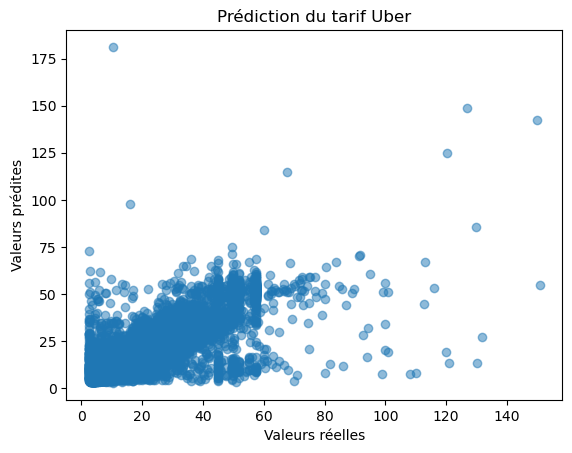

In [97]:
# Étape 7 :

%matplotlib inline

# Importer la bibliothèque de visualisation matplotlib
import matplotlib.pyplot as plt

# Créer un nuage de points comparant les valeurs réelles et les valeurs prédites
# y_test → valeurs réelles (axe x)
# y_pred_rf → valeurs prédites par le modèle Random Forest (axe y)
# alpha=0.5 → rend les points semi-transparents pour mieux voir les zones denses
plt.scatter(y_test, y_pred_rf, alpha=0.5)

# Ajouter un label pour l'axe x
plt.xlabel('Valeurs réelles')

# Ajouter un label pour l'axe y
plt.ylabel('Valeurs prédites')

# Ajouter un titre au graphique
plt.title('Prédiction du tarif Uber')

# Afficher le graphique dans le notebook
plt.show()